# Jack's Car Rental

The code below generates Figure 4.4, which can be found in Chapter 4 (Dynamic Programming) of "Reinforcement Learning: An Introduction" by Andrew Barto and Richard S. Sutton.
The main goal of this lab is to help the understanding of the concepts in Dynamic Programming through a concrete example, given by Jack's Car Rental problem. In particular we will see how the value-function can be computed and how it allows us to better understand the environment, to take meaningful actions.


## Main features of the environment
- 2 locations managed by Jack for a nationwide car rental company
- Customers arrive with an unknown distribution
- If there is a car at the place and time the customer arrives, $10$ dollars are earned by renting it
- Jack can move the cars overnight, paying $2$ dollars for each car
- Cars requested and returned are modelled either through a Poisson random variable (or through a constant value)


## Credits and imports


In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# 2017 Aja Rangaswamy (aja004@gmail.com)                              #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson


## Hard-coded parameters for the environment


In [2]:
# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# Expectations are used to simulate the environment!
# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)
# Moving a negative number of cars means that we are moving them in the opposite direction (from II to I)

# An upper bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UPPER_BOUND = 11
# This is done to save some computational time, since probability at this point is negligible

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poisson_cache = dict()
# We will iteratively build a dictionary for the poisson random variable values, again to save computational time
# The constraint on lambda is only due to "bad" indexing


The following function computes the value of the discrete poisson distribution with a given mean (```lam```) for a particular value (```n```) and then update the dictionary. If we already computed that value in a previous iteration, we just pick it from the dictionary.


In [3]:
def poisson_probability(n, lam):
    global poisson_cache
    # Simple identifier if lam < 10
    key = n * 10 + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]

The following function is the key component in the computation of the value function. Recall that in Dynamic Programming, the environment's transitions are known, or at least they are characterized with a probabilistic model. The probability here is due only to the intrinsic randomness of the environment, therefore we have a perfect knowledge of the consequence of each action.
This knowledge allows us to compute the expected reward as a function of the current state and action.

In particular, we are computing the only quantity that is required to compute the value function for a fixed policy through the Bellman equation:

$V^\pi(s) = \mathbb{E}[r(s, \pi(s)) + V^\pi(s')]$,

or to perform the policy iteration algorithm, that is what will actually use in order to compute the optimal value-function!


In [4]:
def expected_return(state, action, state_value, constant_returned_cars):
    """
    @state: [# of cars in first location, # of cars in second location]
    @action: positive if moving cars from first location to second location,
            negative if moving cars from second location to first location
    @stateValue: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """

    """
    potentially night / end of working day, we decide how many cars to move
    """

    # initialize total return
    returns = 0.0

    # cost for moving cars
    returns -= MOVE_CAR_COST * abs(action)

    # moving cars
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)
    """
    potentially morning & working day, we check every possible scenario
    """
    # We are computing an expectation in at least 2 dimensions, i.e. for each (meaningful) value we need to compute its probability!
    # go through all possible rental requests
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # probability for current combination of rental requests
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # valid rental requests should be less than actual # of cars
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc

            if constant_returned_cars:
                """
                assuming that there is a fixed amount of returned cars, the P to happen is 1
                """
                # get returned cars, those cars can be used for renting tomorrow
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                """
                otherwise we have to marginalize over all possible scenarios
                """
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        prob_return = poisson_probability(
                            returned_cars_first_loc, RETURNS_FIRST_LOC) * poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        prob_ = prob_return * prob
                        returns += prob_ * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

The following function implements the in-place policy iteration algorithm. So starting with a particular policy, the corresponding value-function is considered, which is obtained through multiple sweeps, until convergence. From the new value-function thus obtained, a better policy is found (policy improvement theorem).

/tmp/ipykernel_7850/3509225550.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  policy = np.zeros(value.shape, dtype=np.int)


max value change 196.62783361783843
max value change 134.98823859766583
max value change 91.41415360228913
max value change 67.17097732555717
max value change 51.29055484635097
max value change 38.490910006598256
max value change 29.406139835126396
max value change 25.7210573245398
max value change 22.381602293031108
max value change 19.403858082549107
max value change 16.775773505731138
max value change 14.472515524557764
max value change 12.464101852186673
max value change 10.719367983418636
max value change 9.208062262468673
max value change 7.9019189666795455
max value change 6.775146571130335
max value change 5.804576471008545
max value change 4.969618520007145
max value change 4.252112693842662
max value change 3.636130952405381
max value change 3.107761240497723
max value change 2.654891834022635
max value change 2.2670058994051487
max value change 1.9349911763442265
max value change 1.6509668021548691
max value change 1.4081276418079938
max value change 1.200605567207731
max va

max value change 0.0021719229241625726
max value change 0.0013911772691699298
max value change 0.0008154469396686181
max value change 0.00044598077784030465
max value change 0.00023404084333833453
max value change 0.00012037610918014252
max value change 6.173777160256577e-05
policy stable True


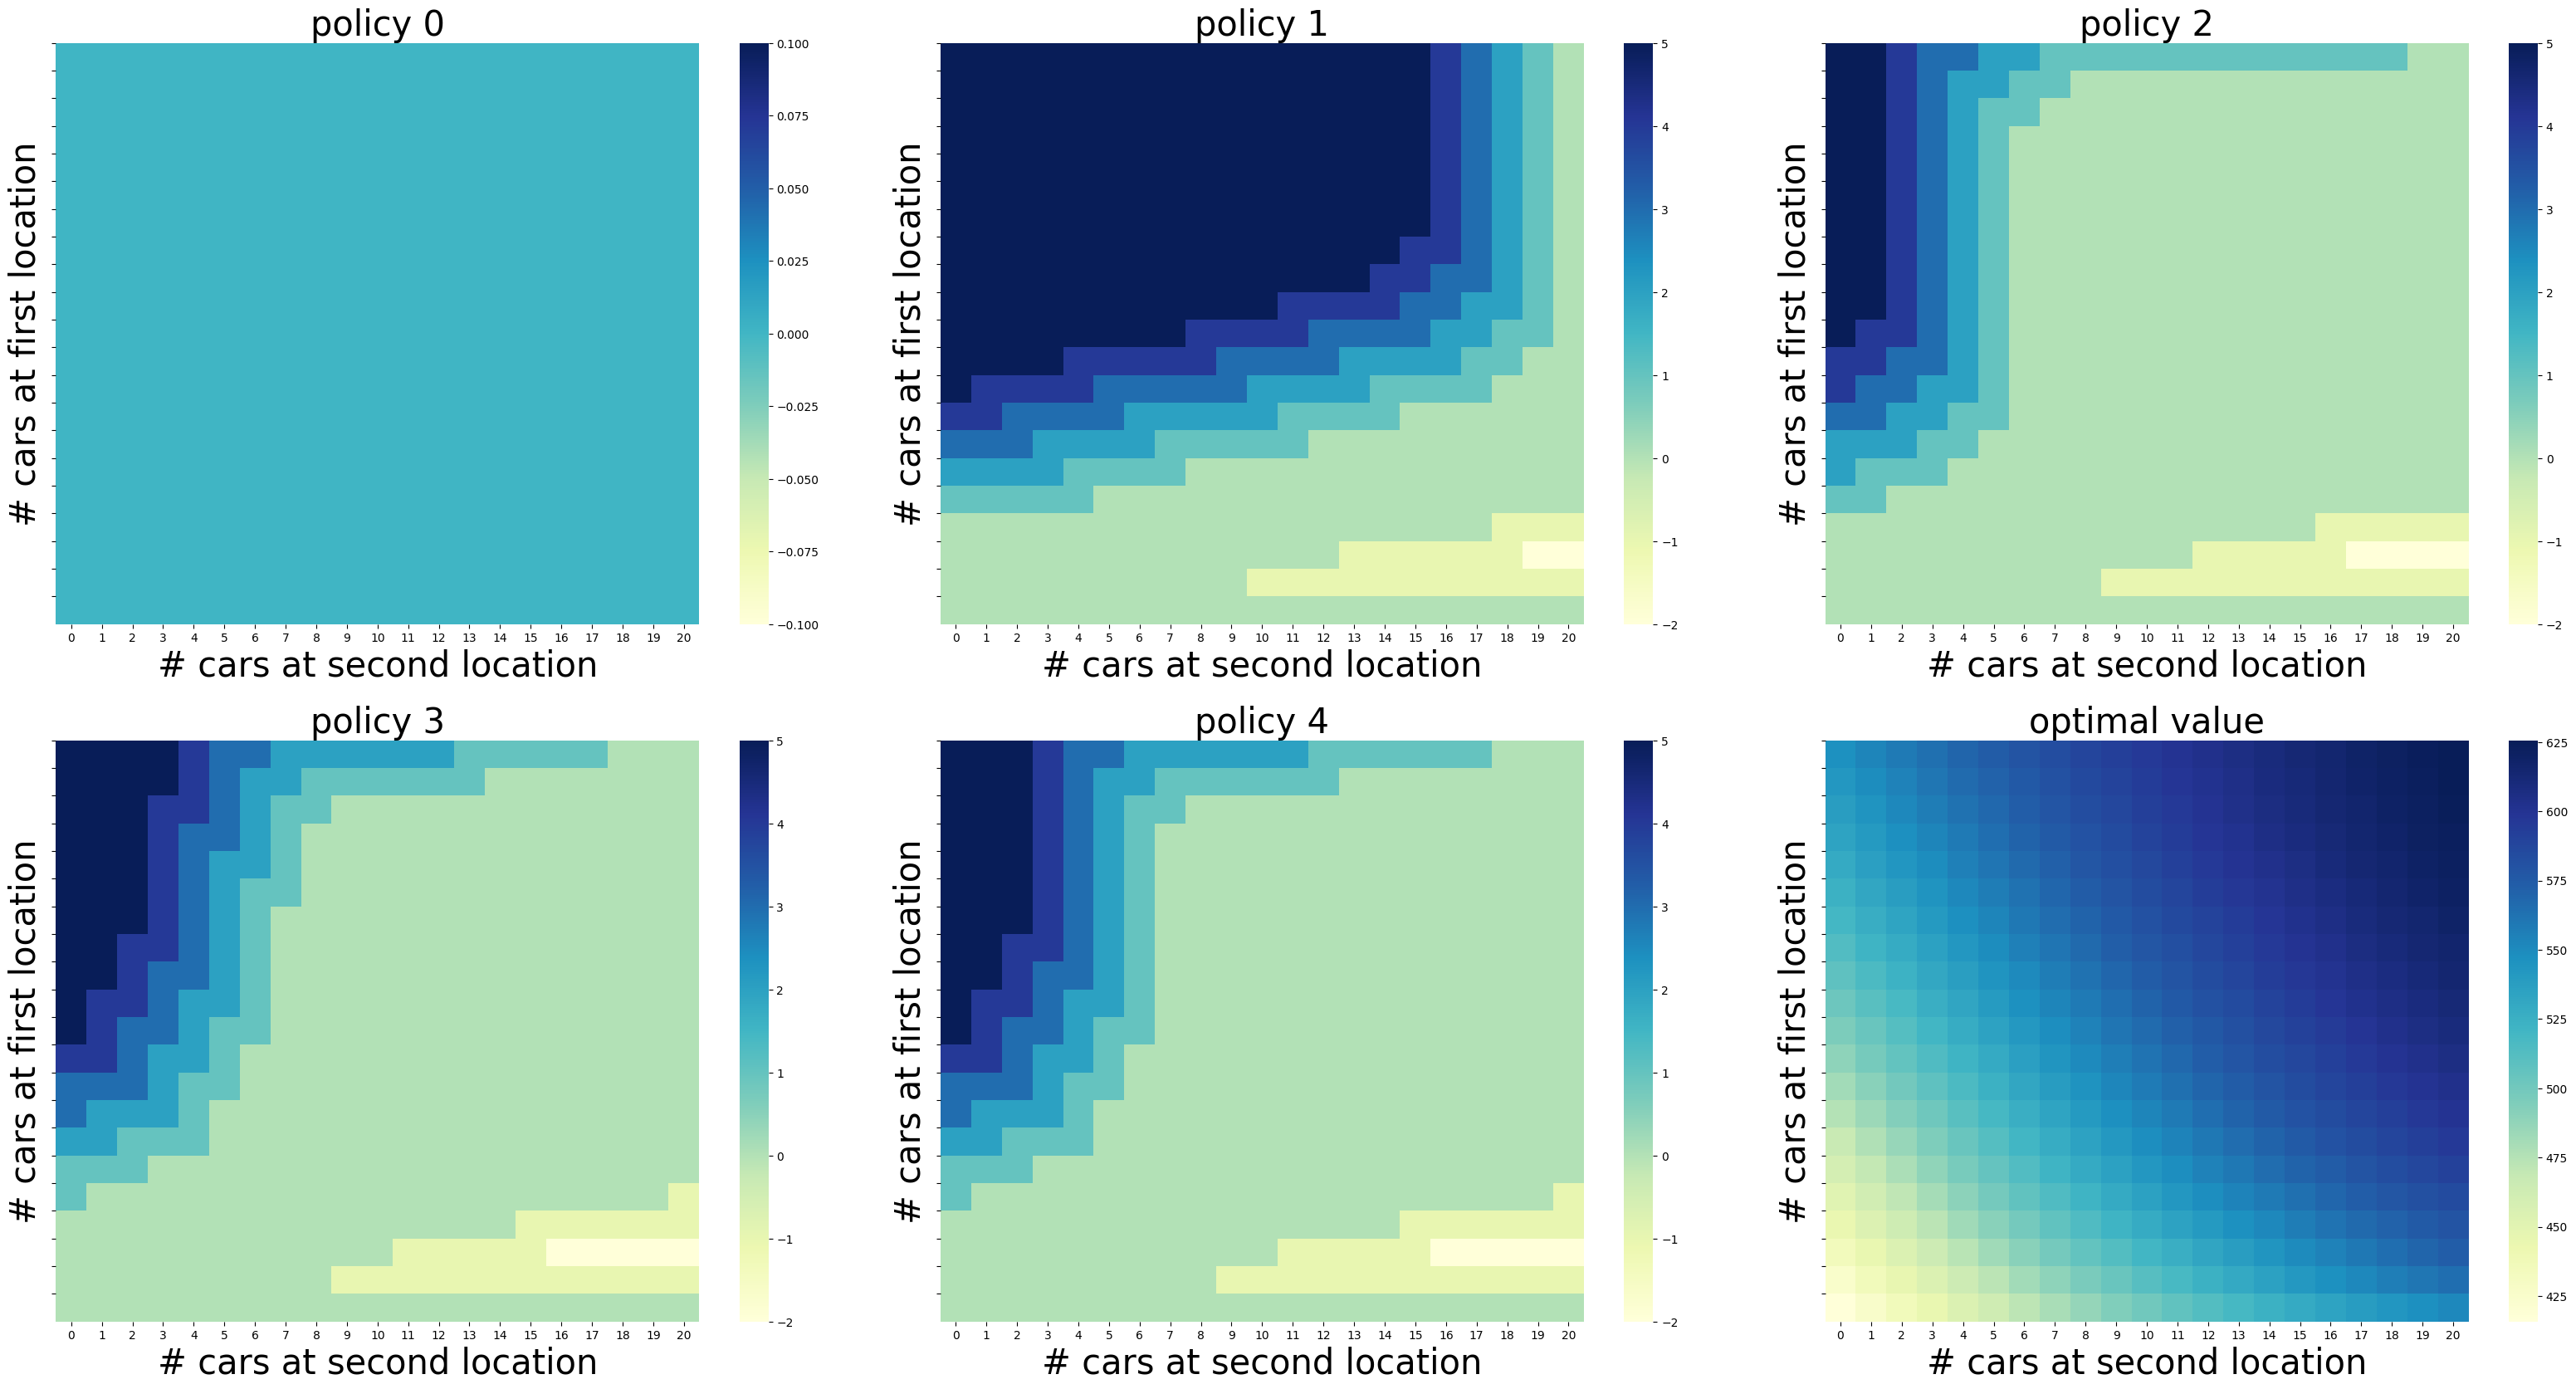

In [5]:
# This is the parameter of the function in the original code
constant_returned_cars = True

# Initialization of the value-function
value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

# We start considering the simplest policy: for every possible state, no car is moved
# It makes sense: if is not clear what a meaningful action might be, better not to pay the cost of moving cars!
policy = np.zeros(value.shape, dtype=np.int)

iterations = 0
_, axes = plt.subplots(2, 3, figsize=(40, 20))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()
while True:
    fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[iterations])
    fig.set_ylabel('# cars at first location', fontsize=30)
    fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
    fig.set_xlabel('# cars at second location', fontsize=30)
    fig.set_title('policy {}'.format(iterations), fontsize=30)

    # policy evaluation (in-place)
    while True:
        old_value = value.copy()
        # Sweep through all states following the same policy
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                new_state_value = expected_return([i, j], policy[i, j], value, constant_returned_cars)
                # in-place update!
                value[i, j] = new_state_value
        max_value_change = abs(old_value - value).max()
        print('max value change {}'.format(max_value_change))
        # termination condition
        if max_value_change < 1e-4:
            break

    # policy improvement
    policy_stable = True
    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            old_action = policy[i, j]
            action_returns = []
            for action in actions:
                # if it is a 'legal' action, i.e. I am not trying to move more cars than I have in that location
                #if (0 <= action <= i) or (-j <= action <= 0):
                if (0 <= action <= i and 0 <= action+j <= MAX_CARS) or (-j <= action <= 0 and 0 <= action+i <= MAX_CARS):
                    action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
                # fraud against the car rental company ---> lawyers, possible imprisonment, very low reward
                else:
                    action_returns.append(-np.inf)
            # Substitution with greedy policy at all states
            new_action = actions[np.argmax(action_returns)]
            policy[i, j] = new_action
            if policy_stable and old_action != new_action:
                policy_stable = False
    print('policy stable {}'.format(policy_stable))
    # If not stable, back to the previous while, and iterate!

    # If stable instead
    if policy_stable:
        fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
        fig.set_ylabel('# cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('# cars at second location', fontsize=30)
        fig.set_title('optimal value', fontsize=30)
        break

    iterations += 1

plt.show()